# A simple model ARMA model and Kalman filter

A collection of simple examples to familiarise myself with statsmodels, will include a simple kalman filter

In [1]:
import numpy as np
print("numpy")
import pandas as pd
print("pandas")
from scipy import stats
print("scipy stats")
import matplotlib.pyplot as plt
print("matplotlib")

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
print("SARIMAX")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print("ACFs")

from sklearn.linear_model import LinearRegression
print("linear regression")

numpy
pandas
scipy stats
matplotlib
SARIMAX
ACFs
linear regression


## Simple AR model with white noise

The simplist time series model is the standard AR model with few coeffcients. This class requires that the initial state and k lagged states are explicitly set so that k+1th state can be generated. Additive gaussian noise was introduced to create uncertainty in the time series states. The const value is seperate but should be inluded in the vector product. 

In [2]:
class simpleTimeSeries:
    """ Simple ARMA model with b = 1 and White noise independant of t:
            Y_t+k+1 = const + a*Y_t+k + ... + a*Y_t + W
    """
    
    def generateSeries(self,coeffs,const, initial_state, n, noise_var,seed):
    #Creator function to generate points can be removed from class
    
        
        # Initialise
        data_series = np.zeros(n);
        rng = np.random.default_rng(seed)
        #rng = np.random.RandomState(seed)
        white_noise = rng.normal(0, noise_var, n) 
        k = initial_state.shape[0];
        
        # Set initial states
        for i,ini_val in enumerate(initial_state):
            data_series[i] = ini_val
        
        # Generate proceeding time series states
        for i in range(k,n):
            data_series[i] = np.dot(coeffs, data_series[i-k:i]) + white_noise[i-1] +const
            
        return data_series
    
    def __init__(self, coeffs, const, initial_state, n, noise_var, seed):
        """ Generate time series for model
        
            coeffs:         coeffcients of AR model (largest delay first) #Should reverse for standard convention
            const:          AR model constant term
            initial_state:  Given k initial states corresponding to k lags in model
            n:              Number of points to generate (includes initial_states)
            noise_var:      Variance of added white noise (set to 0 to exlude)
            seed:           RNG seed
        """
        self.time_series = self.generateSeries(coeffs,const,initial_state,n,noise_var,seed)
    
    def printSeries(self):
        """ Prints time series
        """
        
        for iter in self.time_series:
            print(iter)
            
    #Create graphing functions that section data in series


An AR(1) model was created but the complexity of an AR(2) was more interesting as a stable AR(1) is just an exponential decay. White noise with a variance of 0.05 can be used to represent non-linear systems when added into the state transition calculation. The time series for such a model is created below

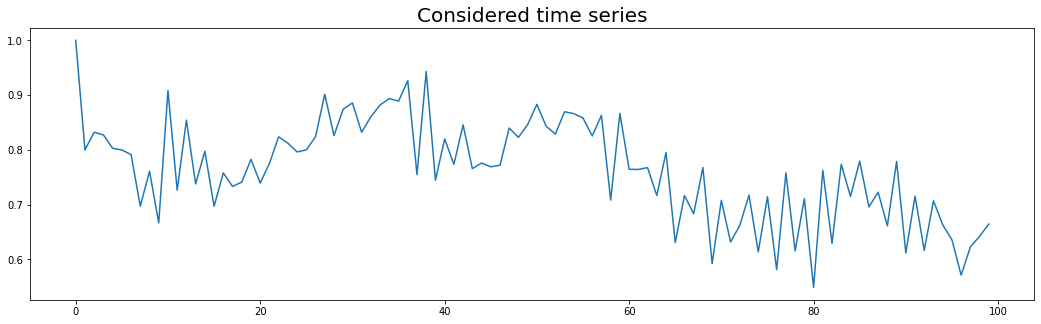

In [3]:
seed = 3
n=100 # number of samples
initial_values = np.array([1,.8])
ar_coeffs = np.array([.8,.2])
ar_const = 0
noise_var = 0.05#0.05

double_exp = simpleTimeSeries(ar_coeffs,ar_const,initial_values,n,noise_var,seed) #Y_t = .2*Y_(t-1) + .8*Y_(t-2) + W
data_series = double_exp.time_series

plt.figure(figsize=(18,5))
plt.title("Considered time series",fontsize=20)
plt.plot(range(n),double_exp.time_series)


endog = pd.DataFrame(data_series,index=range(n)) #Wasted memeory incoporate in class or just use function

# AR(1)
#simple_exp = simpleTimeSeries(np.array([.9]),0,np.array([1]),n,0) #Y_t = .9*Y_(t-1)
#plt.plot(range(n),simple_exp.time_series)

A couple random seeds were tried to get a time series with clear trend. Now since the time series was generated using a linear model with added gaussian noise, we assume no difference is required so d = 0 in our ARIMA model. To test this we plot the ACF function 

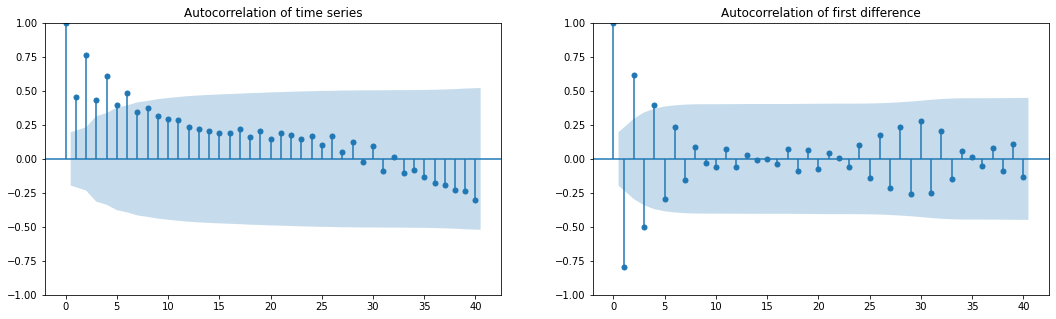

In [4]:
fig, ax = plt.subplots(1,2,figsize=(18,5))
sm.graphics.tsa.plot_acf(endog, lags=40, ax=ax[0], title ="Autocorrelation of time series")
sm.graphics.tsa.plot_acf(endog.diff().dropna(), lags=40, ax=ax[1],title ="Autocorrelation of first difference")
plt.show()

As expected the autocorrelation of first difference value for the first lag has a large negative value. This indicates that the sum was overdifferenced as it cannot have serve oppositely covariance with previous value and contain a large decaying exponential component. Next we look at the PACF and ACF graphs to determine p and q respectively. 

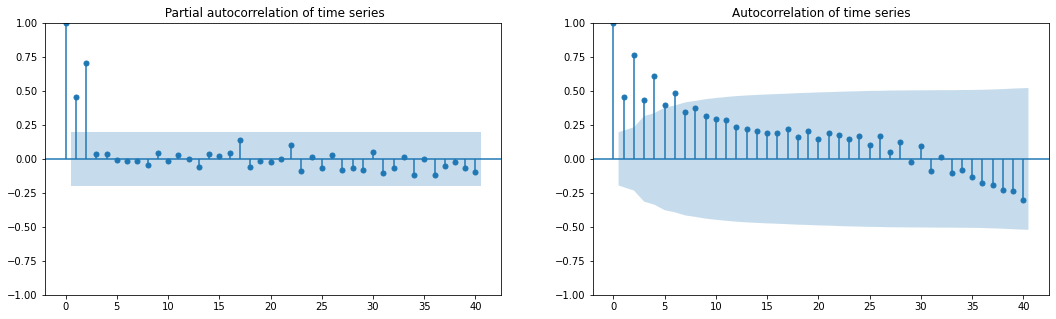

In [5]:
fig, ax = plt.subplots(1,2,figsize=(18,5))
sm.graphics.tsa.plot_pacf(endog, lags=40, method="ywm", ax=ax[0],title =" Partial autocorrelation of time series")
sm.graphics.tsa.plot_acf(endog, lags=40, ax=ax[1], title ="Autocorrelation of time series")
plt.show()

It comes as no suprise that the PACF plot shows two significant values for the first two terms, so it will be an AR(2). Similarly the ACF plot has 6 significant values due to the large amount of noise injected into each state in the equations, however we shall start off ignoring it.

## AR(2) Forecasting

A simple statsmodels ARMA model is fitted to the first 80% of our data with the remaining 20% used as test data for its forecasting.

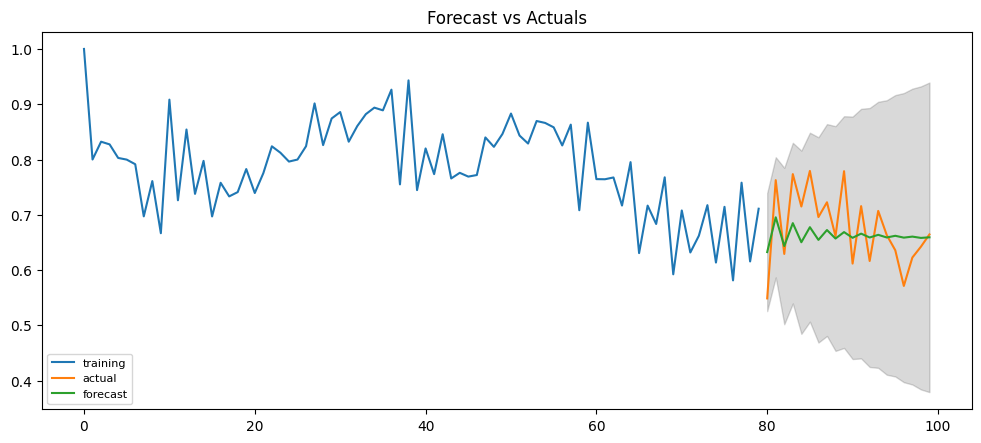

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                   80
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 115.958
Date:                Thu, 14 Apr 2022   AIC                           -225.917
Time:                        12:22:53   BIC                           -218.771
Sample:                             0   HQIC                          -223.052
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1862      0.059      3.163      0.002       0.071       0.302
ar.L2          0.8125      0.059     13.738      0.000       0.697       0.928
sigma2         0.0030      0.000      7.078      0.0

In [6]:
# Training/Testing data split
nobs = len(endog)
n_training = int(nobs * 0.8)
train = endog.iloc[:n_training]
test = endog.iloc[n_training:]
n_test = len(test)+1

# Create simple AR(2) model
my_ar2 = sm.tsa.SARIMAX(train, order=(2,0, 0)).fit()
#my_ar2 = ar2.fit()

# Forecast
forecast = my_ar2.get_forecast(n_test, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(forecast.predicted_mean, index=test.index)
conf = forecast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0], index=test.index)
upper_series = pd.Series(conf.iloc[:,1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='lower left', fontsize=8)
plt.show()

print(my_ar2.summary())

Looking at the summary, it is clear both coeffcients ar.L1 and ar.L2 are significant with P>|z| being less than our significance level of 0.05. The graph reveals that our model quickly converges to a mean as uncertainty increase with each further forecast. This behaviour is expected for our model as it represents a 2 lag process without noise. Since we essentially used white noise to represent non-linear features of the model generating the signal, the generated AR(2) cannot capture this behaviour as seen below.

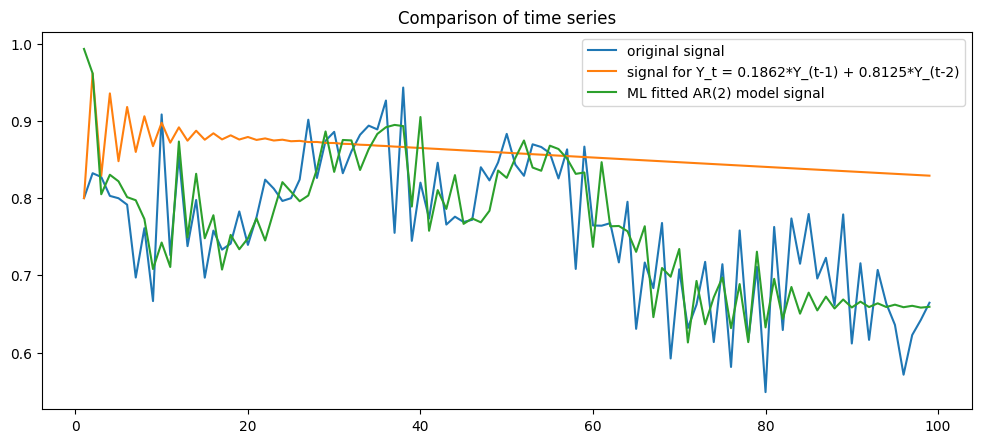

In [7]:
# Use interpolated point-prediction for the model
res_plot = my_ar2.predict(1,99)

# Generate a time series for the AR(2) for our ML selected model parameters
double_res = simpleTimeSeries(np.array([0.8125,0.1862]),0,np.array([1,0.8]),n,0,seed)

# Plotting
plt.figure(figsize=(12,5), dpi=100)

plt.plot(range(1,100),double_exp.time_series[1:100],label='original signal')
plt.plot(range(1,100),double_res.time_series[1:100],label='signal for Y_t = 0.1862*Y_(t-1) + 0.8125*Y_(t-2)')
plt.plot(range(1,100),res_plot,label='ML fitted AR(2) model signal')

plt.title('Comparison of time series')
plt.legend()

A glaring issue is that the value our AR(2) converges is highly dependant on initial values. Since the white noise process is independant of linear model, after a significant change in state due to it we can consider the time series after that point as being generated by a different model, then the prior section. Armed with this we decide that a new model should be created incorporating the latest measurement to best forecast the next value.

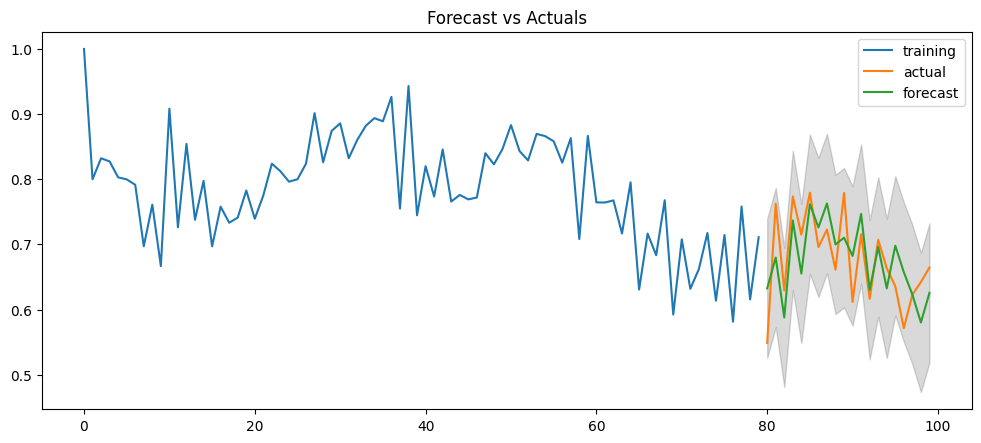

In [8]:
# Setup forecasts
nforecasts = 1 #3
forecasts = {}
lower_conf ={}
upper_conf = {}

my_ar2_f = sm.tsa.SARIMAX(train, order=(2,0, 0)).fit()


# Make as pandas series
#fc_series = pd.Series(forecast.predicted_mean, index=test.index)
#conf = forecast.conf_int(alpha=0.05)
#lower_series = pd.Series(conf.iloc[:,0], index=test.index)
#upper_series = pd.Series(conf.iloc[:,1], index=test.index)

# Save initial forecast
#forecasts[train.index[-1]] = my_ar2_f.forecast(steps=nforecasts)
#forecast = my_ar2_f.get_forecast(1, alpha=0.05)  # 95% conf
#forecasts[train.index[-1]] = forecast.predicted_mean
#conf = forecast.conf_int(alpha=0.05)
#print(conf.iloc[:,0])
#lower_conf[train.index[-1]] = conf.iloc[:,0]
#upper_conf[train.index[-1]] = conf.iloc[:,1]
forecast = my_ar2_f.get_forecast(1, alpha=0.05)
forecasts[test.index[0]] = forecast.predicted_mean.iloc[0]
conf = forecast.conf_int(alpha=0.05)
lower_conf[test.index[0]] = conf.iloc[0,0]
upper_conf[test.index[0]] = conf.iloc[0,1]

# Step through the rest of the sample
#for t in range(n_training, nobs):
for t in range(n_training, nobs):
    # Update the results by appending the next observation
    updated = endog.iloc[t:t+1]
    my_ar2_f = my_ar2_f.extend(updated)

    # Save the new set of forecasts
    #forecasts[updated.index[0]] = my_ar2_f.forecast(steps=nforecasts)
    forecast = my_ar2_f.get_forecast(1, alpha=0.05)  # 95% conf

    forecasts[updated.index[0]+1] = forecast.predicted_mean.iloc[0]
    conf = forecast.conf_int(alpha=0.05)
    lower_conf[updated.index[0]+1] = conf.iloc[0,0]
    upper_conf[updated.index[0]+1] = conf.iloc[0,1]
    #forecasts[updated.index[0]] = forecast.predicted_mean.iloc[0]
    #conf = forecast.conf_int(alpha=0.05)
    #lower_conf[updated.index[0]] = conf.iloc[0,0]
    #upper_conf[updated.index[0]] = conf.iloc[0,1]

# Combine all forecasts into a dataframe
#forecasts = pd.concat(forecasts, axis=1)


#print(forecasts.iloc[15,15])
#temp = np.zeros(20)
#for t in range(0,20):
#    temp[t] = forecasts.iloc[t,t]

fc_series = pd.Series(forecasts, dtype=np.float64, index=test.index)
lower_conf = pd.Series(lower_conf, dtype=np.float64, name='lower y', index=test.index)
upper_conf = pd.Series(upper_conf, dtype=np.float64, name='upper y', index=test.index)
    

## Plot
plt.figure(figsize=(12,5), dpi=100)
plt.title('Forecast vs Actuals')
plt.plot(train, label='training')
plt.plot(test, label='actual')
#plt.plot(range(n_training, nobs),temp, label='forecast')
plt.plot(test.index,fc_series, label='forecast')
plt.fill_between(test.index, lower_conf, upper_conf, color='k', alpha=.15)

plt.legend()

#print(forecast.predicted_mean.iloc[0])

As expected a significant improvement was obtained in the forecast prediction, with uncertainty remaining low. A problem with this approach is that noise in the system/measurements is not removed. To remedy this we could consider using a Kalman filter to better smooth the time series or decomposing the data into multiple independant signals using Independant Component Analysis (ICA). However firstly we will statistically analyse the signal to better inform our approach.

## Statistical Analysis

DescribeResult(nobs=100, minmax=(array([0.54879234]), array([1.])), mean=array([0.76374094]), variance=array([0.0083909]), skewness=array([-0.1565873]), kurtosis=array([-0.40004383]))


<function matplotlib.pyplot.show(close=None, block=None)>

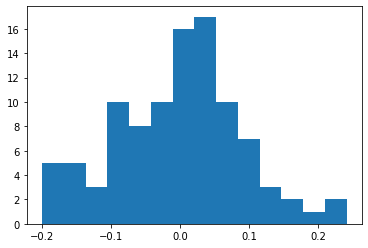

In [9]:
print(stats.describe(endog))
plt.hist(endog.diff(), bins=14)
plt.show

Most importantly we see a kurtosis of -0.4 which means that a Kalman filter should provide a reasonable solution with high variance. If this isn't the case an unscented Kalman filter should work.

One standard deviation is:  0.09160183596181067
Two standard deviations is:  0.18320367192362133
Three standard deviations is:  0.274805507885432


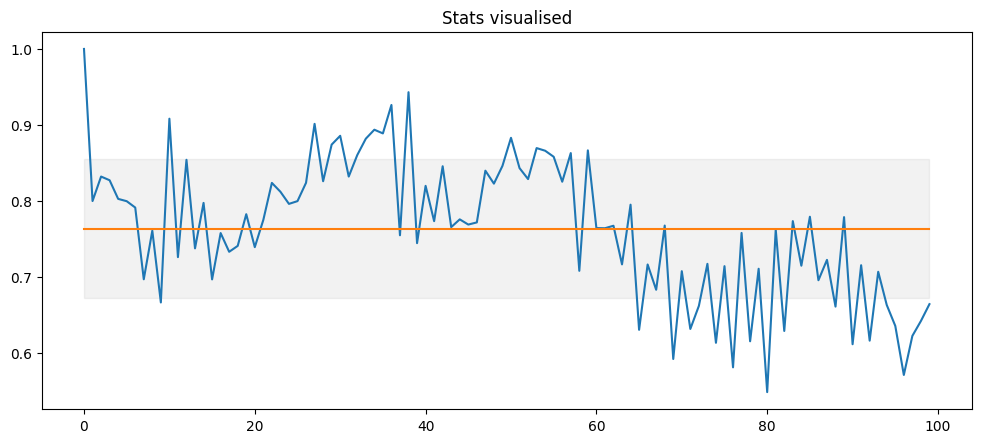

In [10]:
endog_std = stats.tstd(endog)[0]
endog_std_2 = endog_std*2
endog_std_3 = endog_std*3
print("One standard deviation is: ",endog_std)
print("Two standard deviations is: ",endog_std_2)
print("Three standard deviations is: ",endog_std_3)

mean_line = np.ones(n)*0.76374094
std1_lower = np.ones(n)*0.76374094 - endog_std
std1_upper = np.ones(n)*0.76374094 + endog_std
std2_lower = np.ones(n)*0.76374094 - endog_std_2
std2_upper = np.ones(n)*0.76374094 + endog_std_2
std3_lower = np.ones(n)*0.76374094 - endog_std_3
std3_upper = np.ones(n)*0.76374094 + endog_std_3
    
## Plot
plt.figure(figsize=(12,5), dpi=100)
plt.title('Stats visualised')
plt.plot(endog)
plt.plot(mean_line, label='mean')
plt.fill_between(endog.index,std1_lower, std1_upper, color='k', alpha=.05)


#plt.legend()


In [33]:
def partitionProcessByStd(process,mean,std,k,window_size):
    """ For a process if enough values (k) occur outside 1 standard deviation of a process in a specified window, 
        a new process segment with mean shifted by one standard deviation in appropriate direction is considered.
    """
    centre_lims = np.array([mean - std, mean + std])
    window = 0
    flag_l = 0
    flag_u = 0
    run = np.array([[0],[mean]])
    
    for i in range(1,len(process)):
    
        if(window > window_size):
            window = 0
            flag_l = 0
            flag_u = 0
        elif(window > 0):
            window += 1
            
        if (process.iloc[i][0] < centre_lims[0]):
        
            if (flag_l == 1):
                mean -= std
                run = np.append(run, np.array([i,mean]).reshape(2,1), axis=1)
                centre_lims[0] -= std
                centre_lims[1] -= std
                flag_l = 0
                window = 0
            else:
                flag_l = 1
                window = 1
        
        elif(process.iloc[i][0] > centre_lims[1]):
        
            if (flag_u == 1):
                mean += std
                run = np.append(run, np.array([i,mean]).reshape(2,1), axis=1)
                centre_lims[0] += endog_std
                centre_lims[1] += endog_std
                flag_u = 0
                window = 0
            else:
                flag_u = 1
                window = 1
                
    return run
    

In [38]:
a = partitionProcessByStd(endog,0.76374094 ,endog_std,2,2)
print(a)

[[ 0.         29.         39.         54.         65.         71.
  85.         90.        ]
 [ 0.76374094  0.85534278  0.76374094  0.85534278  0.76374094  0.6721391
   0.76374094  0.6721391 ]]


In [35]:
#centre_lims = np.array([0.76374094 - endog_std,0.76374094 + endog_std])
#window_size = 2
#window = 0
#flag_l = 0
#flag_u = 0

#for i in range(1,n):
    
#    if(window > window_size):
#        window = 0
#        flag_l = 0
#        flag_u = 0
#    elif(window > 0):
#        window += 1
    
#    if (endog.iloc[i][0] < centre_lims[0]):
        
#        if (flag_l == 1):
#            print("less than at index: ",i)
#            centre_lims[0] -= endog_std
#            centre_lims[1] -= endog_std
#            flag_l = 0
#            window = 0
#        else:
#            flag_l = 1
#            window = 1
        
#    elif(endog.iloc[i][0] > centre_lims[1]):
        
#        if (flag_u == 1):
#            print("graeter than at index: ",i)
#            centre_lims[0] += endog_std
#            centre_lims[1] += endog_std
#            flag_u = 0
#            window = 0
#        else:
#            flag_u = 1
#            window = 1

In [50]:
def partitianedProcessPlotter(process,seg_mat):
    # Plots process and partians as mean lines
    
    plt.figure(figsize=(12,5), dpi=100)
    plt.title('Partitioned time series')
    plt.plot(process)
    
    for i in range(seg_mat.shape[1]):
        
        if (i < seg_mat.shape[1]-1):
            mean_line = np.ones(int(seg_mat[0,i+1])-int(seg_mat[0,i]))*seg_mat[1,i]
            plt.plot(range(int(seg_mat[0,i]),int(seg_mat[0,i+1])),mean_line, color='r')
        else:
            mean_line = np.ones(len(process)-int(seg_mat[0,i]))*seg_mat[1,i]
            plt.plot(range(int(seg_mat[0,i]),len(process)),mean_line, color='r')
        #

IndexError: index 8 is out of bounds for axis 1 with size 8

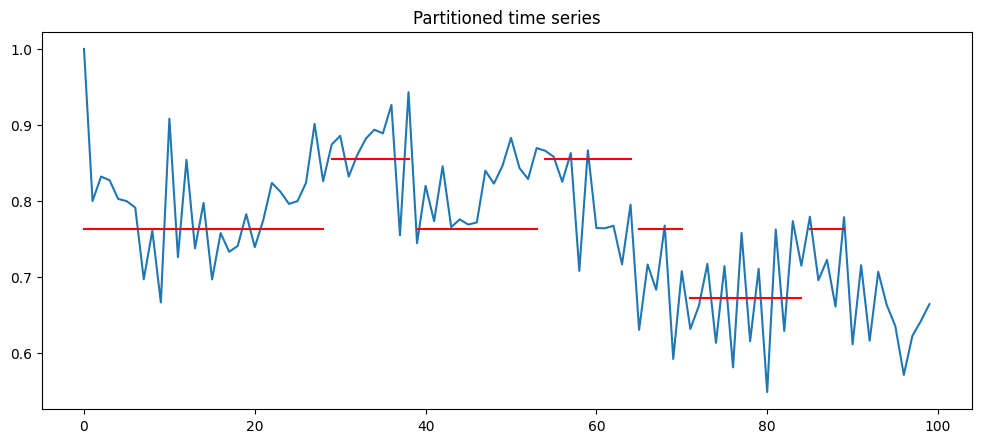

In [51]:
partitianedProcessPlotter(endog,a)

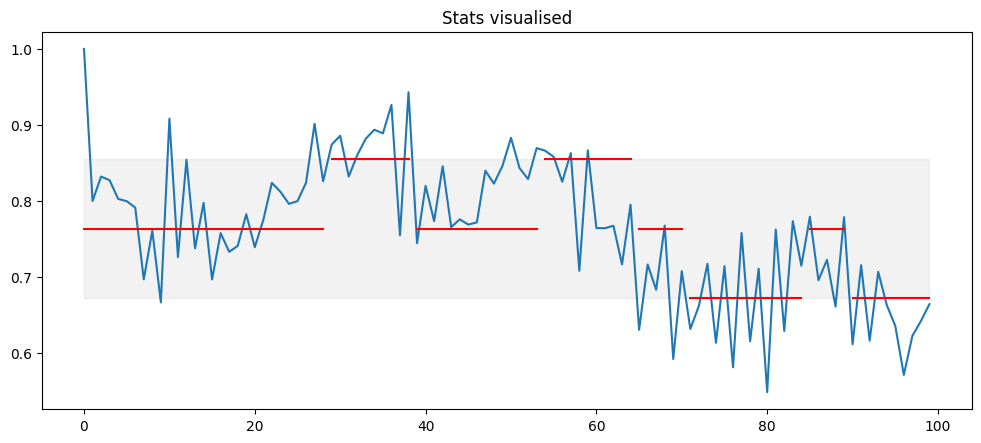

In [13]:
mean_line_1 = np.ones(29)*0.76374094
mean_line_2 = np.ones(39-29)*(mean_line_1[0]+endog_std)
mean_line_3 = np.ones(54-39)*(mean_line_2[0]-endog_std)
mean_line_4 = np.ones(65-54)*(mean_line_3[0]+endog_std)
mean_line_5 = np.ones(71-65)*(mean_line_4[0]-endog_std)
mean_line_6 = np.ones(85-71)*(mean_line_5[0]-endog_std)
mean_line_7 = np.ones(90-85)*(mean_line_6[0]+endog_std)
mean_line_8 = np.ones(n-90)*(mean_line_7[0]-endog_std)
    
## Plot
plt.figure(figsize=(12,5), dpi=100)
plt.title('Stats visualised')
plt.plot(endog)
plt.plot(range(0,29),mean_line_1, color='r')
plt.plot(range(29,39),mean_line_2, color='r')
plt.plot(range(39,54),mean_line_3, color='r')
plt.plot(range(54,65),mean_line_4, color='r')
plt.plot(range(65,71),mean_line_5, color='r')
plt.plot(range(71,85),mean_line_6, color='r')
plt.plot(range(85,90),mean_line_7, color='r')
plt.plot(range(90,n),mean_line_8, color='r')

plt.fill_between(endog.index,std1_lower, std1_upper, color='k', alpha=.05)
#plt.legend()

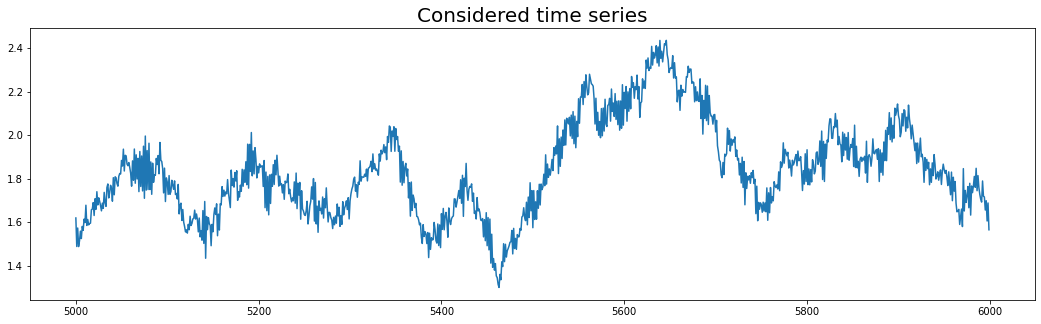

In [14]:
seed = 3
nn=10000 # number of samples
initial_values = np.array([1,.8])
ar_coeffs = np.array([.8,.2])
ar_const = 0
noise_var = 0.05#0.05

double_exp = simpleTimeSeries(ar_coeffs,ar_const,initial_values,nn,noise_var,seed) #Y_t = .2*Y_(t-1) + .8*Y_(t-2) + W
data_series = double_exp.time_series

plt.figure(figsize=(18,5))
plt.title("Considered time series",fontsize=20)
k1 = 5000
k2 = 6000
plt.plot(range(k1,k2),double_exp.time_series[k1:k2])

# AR(1)
#simple_exp = simpleTimeSeries(np.array([.9]),0,np.array([1]),n,0) #Y_t = .9*Y_(t-1)
#plt.plot(range(n),simple_exp.time_series)

In [15]:
#plt.plot(range(n),double_exp.time_series,label='original')
##plt.plot(range(n),double_res.time_series,label='reconstructed')
##double_nonoise = simpleTimeSeries(np.array([.8,.2]),0,np.array([1,0.4]),n,0)
##plt.plot(range(n),double_nonoise.time_series,label='original no noise')
##plt.plot(range(2,10),res_plot,label='ar model')
#res_plot = my_ar2.predict(5,n-1)
#plt.plot(range(5,n),res_plot,label='ar model')

#plt.legend()

In [16]:
#print(double_nonoise.time_series[99])
#endog = pd.DataFrame(data_series,index=range(n))
# Setup forecasts
#nforecasts = 3
#forecasts = {}

## Get the number of initial training observations
#nobs = len(endog)
#n_init_training = int(nobs * 0.8)

## Create model for initial training sample, fit parameters
#training_endog = endog.iloc[:n_init_training]
#mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='n')
#res = mod.fit()

## Save initial forecast
#forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
#for t in range(n_init_training, nobs):
#    # Update the results by appending the next observation
#    updated_endog = endog.iloc[t:t+1]
#    res = res.extend(updated_endog)

#    # Save the new set of forecasts
#    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

## Combine all forecasts into a dataframe
#forecasts = pd.concat(forecasts, axis=1)

#print(forecasts.iloc[:5, :5])
#print(double_res.time_series[99])

##res = AutoReg(simple_exp.time_series,1).fit()
##res = AutoReg(double_exp.time_series[0:50],2).fit()
##print(res.summary())

#std1_lims = np.zeros((2,n))
#std2_lims = np.zeros((2,n))
#std3_lims = np.zeros((2,n))

#for i in range(n):
    
#    val = endog.iloc[i][0]
#    std1_lims[0,i] = val - endog_std
#    std1_lims[1,i] = val + endog_std
#    std2_lims[0,i] = val - endog_std_2
#    std2_lims[1,i] = val + endog_std_2
#    std3_lims[0,i] = val - endog_std_3
#    std3_lims[1,i] = val + endog_std_3

#mean_line = np.ones(100)*0.76374094
    
## Plot
#plt.figure(figsize=(12,5), dpi=100)
#plt.title('Stats visualised')
#plt.plot(endog)
#plt.plot(mean_line, label='mean')
#plt.fill_between(endog.index,std1_lims[0,:], std1_lims[1,:], color='k', alpha=.05)
#plt.fill_between(endog.index,std2_lims[0,:], std2_lims[1,:], color='k', alpha=.05)
#plt.fill_between(endog.index,std3_lims[0,:], std3_lims[1,:], color='k', alpha=.05)

#plt.legend()